# Градиентный бустинг над решающими деревьями

### Вы научитесь:

- работать с градиентным бустингом и подбирать его гиперпараметры
- сравнивать разные способы построения композиций
- понимать, в каком случае лучше использовать случайный лес, а в каком — градиентный бустинг
- использовать метрику `log-loss`

### Введение

Построение композиции — важный подход в машинном обучении, который позволяет объединять большое количество слабых алгоритмов в один сильный. Данный подход широко используется на практике в самых разных задачах.


На лекциях был рассмотрен метод градиентного бустинга, который последовательно строит композицию алгоритмов, причем каждый следующий алгоритм выбирается так, чтобы исправлять ошибки уже имеющейся композиции. Обычно в качестве базовых алгоритмов используют деревья небольшой глубины, поскольку их достаточно легко строить, и при этом они дают нелинейные разделяющие поверхности.


Другой метод построения композиций — случайный лес. В нем, в отличие от градиентного бустинга, отдельные деревья строятся независимо и без каких-либо ограничений на глубину — дерево наращивается до тех пор, пока не покажет наилучшее качество на обучающей выборке.


В этом задании мы будем иметь дело с задачей классификации. В качестве функции потерь будем использовать `log-loss`:

$$ L(y, z) = -ylogz - (1 - y)log(1 - z) $$

Здесь через *y* обозначен истинный ответ, через *z* — прогноз алгоритма. Данная функция является дифференцируемой, и поэтому подходит для использования в градиентном бустинге. Также можно показать, что при ее использовании итоговый алгоритм будет приближать истинные вероятности классов.

### Реализация в sklearn

В пакете `scikit-learn` градиентный бустинг реализован в модуле `ensemble` в виде классов [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) и [GradientBoostingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html). Основные параметры, которые будут интересовать нас: `n_estimators`, `learning_rate`. Иногда может быть полезен параметр `verbose` для отслеживания процесса обучения.


Чтобы была возможность оценить качество построенной композиции на каждой итерации, у класса есть метод `staged_decision_function`. Для заданной выборки он возвращает ответ на каждой итерации.


Помимо алгоритмов машинного обучения, в пакете `scikit-learn` представлено большое число различных инструментов. В этом задании будет предложено воспользоваться функцией `train_test_split` модуля `model_selection`. С помощью нее можно разбивать выборки случайным образом. На вход можно передать несколько выборок (с условием, что они имеют одинаковое количество строк). Пусть, например, имеются данные `X` и `y`, где `X` — это признаковое описание объектов, `y` — целевое значение. Тогда следующий код будет удобен для разбиения этих данных на обучающее и тестовое множества:

```python
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
```

Обратите внимание, что при фиксированном параметре `random_state` результат разбиения можно воспроизвести.

Метрика [log-loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) реализована в пакете metrics: [sklearn.metrics.log_loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html). Заметим, что данная метрика предназначена для классификаторов, выдающих оценку принадлежности классу, а не бинарные ответы. И градиентный бустинг, и случайный лес умеют строить такие прогнозы — для этого нужно использовать метод `predict_proba`:

```python
pred = clf.predict_proba(X_test)
```

Метод `predict_proba` возвращает матрицу, i-й столбец которой содержит оценки принадлежности i-му классу.


Для рисования кривых качества на обучении и контроле можно воспользоваться следующим кодом:

```python
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(test_loss, 'r', linewidth=2)
plt.plot(train_loss, 'g', linewidth=2)
plt.legend(['test', 'train'])
```

### Материалы

- [Подробнее о градиентном бустинге и особенностях его применения к деревьям](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture09-ensembles.pdf)

### Данные

- В рамках данного задания мы рассмотрим датасет с конкурса [Predicting a Biological Response](https://www.kaggle.com/c/bioresponse).

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import log_loss
from matplotlib import pyplot as plt
import operator, os
from sklearn.ensemble import RandomForestClassifier as RFC

%matplotlib inline

In [4]:
def answer(filename, *args):
    f = open(filename, 'w')
    s = ' '.join([str(a) for a in args])
    f.write(s)
    f.close()

In [5]:
def sigma(y):
    return 1 / (1 + np.exp(-y))

In [6]:
def plot(train, test, name_postfix):
    plt.figure()
    plt.plot(train, 'r', linewidth=3)
    plt.plot(test, 'b', linewidth=3)
    plt.legend(['train', 'test'])
    plt.savefig('plots/rate_' + str(name_postfix) + '.png')

# 1
Загрузите выборку из файла `gbm-data.csv` с помощью `pandas` и преобразуйте ее в массив `numpy` (параметр `values` у датафрейма). В первой колонке файла с данными записано, была или нет реакция. Все остальные колонки (`d1 - d1776`) содержат различные характеристики молекулы, такие как размер, форма и т.д. Разбейте выборку на обучающую и тестовую, используя функцию `train_test_split` с параметрами `test_size = 0.8` и `random_state = 241`.

In [8]:
data = pd.read_csv('gbm-data.csv')

In [9]:
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


In [12]:
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

In [13]:
y[:5]

array([1, 1, 1, 1, 0])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

In [15]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

X_train:  (750, 1776)
X_test:  (3001, 1776)
y_train:  (750,)
y_test:  (3001,)


In [16]:
PLOT_DIR = 'plots'
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

# 2
Обучите `GradientBoostingClassifier` с параметрами `n_estimators=250`, `verbose=True`, `random_state=241` и для каждого значения `learning_rate` из списка `[1, 0.5, 0.3, 0.2, 0.1]` проделайте следующее:

- Используйте метод `staged_decision_function` для предсказания качества на обучающей и тестовой выборке на каждой итерации.
- Преобразуйте полученное предсказание с помощью сигмоидной функции по формуле `1 / (1 + e^{−y_pred})`, где `y_pred` — предсказанное значение.
- Вычислите и постройте график значений `log-loss` (которую можно посчитать с помощью функции `sklearn.metrics.log_loss`) на обучающей и тестовой выборках, а также найдите минимальное значение метрики и номер итерации, на которой оно достигается.

# 3
Как можно охарактеризовать график качества на тестовой выборке, начиная с некоторой итерации: переобучение (overfitting) или недообучение (underfitting)? В ответе укажите одно из слов overfitting либо underfitting.

# 4
Приведите минимальное значение log-loss на тестовой выборке и номер итерации, на котором оно достигается, при learning_rate = 0.2.

      Iter       Train Loss   Remaining Time 
         1           1.0190           17.84s
         2           0.9192           17.72s
         3           0.8272           17.39s
         4           0.7834           17.20s
         5           0.7109           16.90s
         6           0.6368           16.78s
         7           0.5797           16.92s
         8           0.5610           16.45s
         9           0.5185           16.50s
        10           0.4984           16.55s
        20           0.1999           15.99s
        30           0.1313           15.02s
        40           0.0790           14.96s
        50           0.0511           14.28s
        60           0.0352           13.50s
        70           0.0245           12.80s
        80           0.0162           12.21s
        90           0.0114           11.48s
       100           0.0077           10.66s
       200           0.0004            3.23s
      Iter       Train Loss   Remaining Time 
        

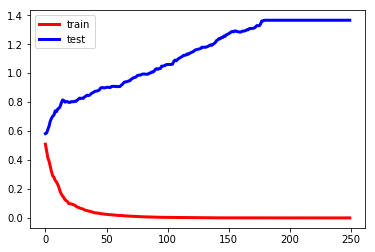

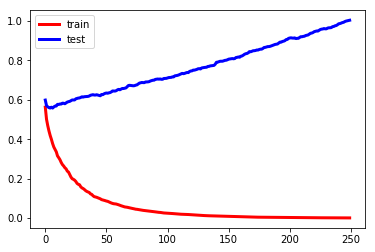

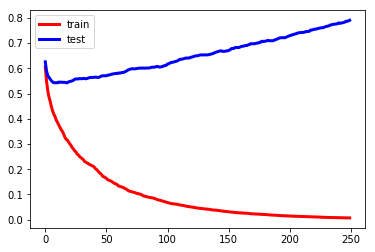

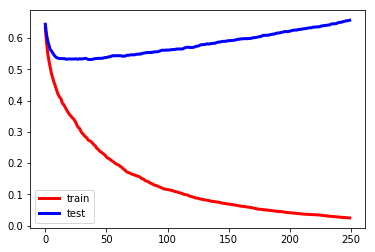

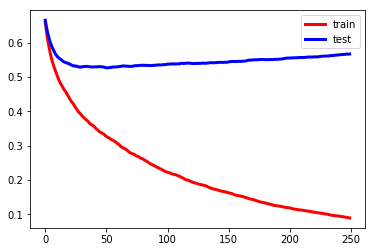

In [22]:
learning_rates = np.array([1, 0.5, 0.3, 0.2, 0.1])
    
for learning_rate in learning_rates:
    clf = GBC(learning_rate=learning_rate, n_estimators=250, verbose=True, random_state=241)
    clf.fit(X_train, y_train)
    
    y_pred_train = [sigma(score) for score in clf.staged_decision_function(X_train)]
    y_pred_test = [sigma(score) for score in clf.staged_decision_function(X_test)]
    
    # count log_loss
    train_loss = np.array([log_loss(y_train, y_pred) for y_pred in y_pred_train])
    test_loss = np.array([log_loss(y_test, y_pred) for y_pred in y_pred_test])
    
    plot(train_loss, test_loss, learning_rate)
    min_loss_index, min_loss = min(enumerate(test_loss), key=operator.itemgetter(1))
    
    # Приведите минимальное значение log-loss на тестовой выборке и номер итерации,
    # на котором оно достигается, при learning_rate = 0.2.
    if learning_rate == 0.2:
        answer('submission-2.txt', min_loss, min_loss_index)
        
        # 3. Как можно охарактеризовать график качества на тестовой выборке,
        # начиная с некоторой итерации: переобучение (overfitting) или
        # недообучение (underfitting)?
        #
        # По графику можно видеть, что хотя на обучающей выборке качество возрастает,
        # на тестовой выборке после примерно 50 итерации качество начинает убывать.
        fitting = 'overfitting' if test_loss[int(3.*test_loss.size/4.) :].mean() > test_loss.mean() else 'underfitting'
        answer('submission-1.txt', fitting)

# 5
На этих же данных обучите `RandomForestClassifier` с количеством деревьев, равным количеству итераций, на котором достигается наилучшее качество у градиентного бустинга из предыдущего пункта, c `random_state=241` и остальными параметрами по умолчанию. Какое значение `log-loss` на тесте получается у этого случайного леса? (Не забывайте, что предсказания нужно получать с помощью функции `predict_proba`. В данном случае брать сигмоиду от оценки вероятности класса не нужно)

In [29]:
forest = RFC(n_estimators=min_loss_index, random_state=241)
forest.fit(X_train, y_train)

y_forest = forest.predict_proba(X_test)
forest_loss = log_loss(y_test, y_forest)

print(forest_loss)
answer('submission-3.txt', forest_loss)

0.538873466003
